<a href="https://colab.research.google.com/github/ravitejareddy-dodda/CMPE-255-Data-Mining/blob/main/Approximate_Nearest_Neighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [3]:
! pip install nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 137 kB/s 
     |████████████████████████████████| 188 kB 41.1 MB/s 


In [4]:
! pip install faiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.9 MB/s 


In [5]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (236 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Sel

In [6]:
! pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 7.5 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395183 sha256=fb3e71df4a04c941dbd6a067db4cd2928b817f010879808663f33584b86d9d27
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [7]:
digits = load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
X.shape

(901, 64)

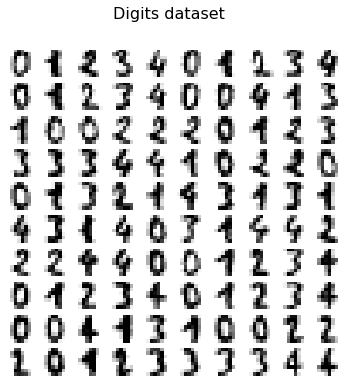

In [8]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Digits dataset", fontsize=16)

In [9]:
from sklearn.manifold import TSNE

tsne_2 = TSNE()
data_embeddings_tsne_2 = tsne_2.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [10]:
data_embeddings_tsne_2.shape

(901, 2)

In [11]:
import nmslib

In [12]:
hnsw_index = nmslib.init(method='hnsw', space='cosinesimil')
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})

In [13]:
y[80]

0

In [14]:
hnsw_output = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k=10)
hnsw_output_list = [y[i] for i in hnsw_output[0]]
hnsw_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
import faiss

In [16]:
exhaustive_search = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
exhaustive_search.add(data_embeddings_tsne_2)

In [17]:
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[80:81], 10) 
exhaustive_search_output_list = [y[i] for i in indices[0]]

In [18]:
exhaustive_search_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
number_of_partition = 8
search_in_x_partitions = 2
subvector_size = 8

pq_quantizer = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
pq = faiss.IndexIVFPQ(pq_quantizer, data_embeddings_tsne_2.shape[1], number_of_partition, search_in_x_partitions, subvector_size)
pq.train(data_embeddings_tsne_2)
pq.add(data_embeddings_tsne_2)

In [20]:
distances, indices = pq.search(data_embeddings_tsne_2[90:91], 10) 
pq_output_list =  [y[i] for i in indices[0]]
pq_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [21]:
lsh = faiss.IndexLSH(data_embeddings_tsne_2.shape[1], 4)
lsh.add(data_embeddings_tsne_2)

In [22]:
distances, indices = lsh.search(data_embeddings_tsne_2[80:81], k=10)
lsh_output_list =  [y[i] for i in indices[0]]
lsh_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
import annoy

In [24]:
number_of_trees = 5
annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])
for i, vec in enumerate(data_embeddings_tsne_2):
  annoy_index.add_item(i, vec.tolist())
annoy_index.build(number_of_trees)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [25]:
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[90].tolist(), 10)
annoy_output_list = [y[i] for i in annoy_indices]

In [26]:
annoy_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [27]:
graph_index = faiss.IndexHNSWFlat(data_embeddings_tsne_2.shape[1], 10)
graph_index.add(data_embeddings_tsne_2)

distances, indices = graph_index.search(data_embeddings_tsne_2[90:91], k=10)
graph_output_list = [y[i] for i in indices[0]]
graph_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

**REFERENCES**

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_approximate_nearest_neighbors.ipynb

https://www.youtube.com/watch?v=OO7Y5wQWnQs&ab_channel=ProgrammingKnowledge

https://github.com/spotify/annoy

https://www.youtube.com/watch?v=7_CIQf73Oj0&ab_channel=wiqaaas